# Libraries and loading in the data

In [1]:
import os
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
plt.style.use('/Users/kyle/GoogleDrive/personal.mplstyle')

# Plotting Functions

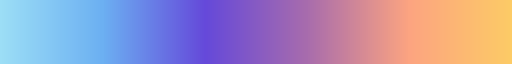

In [20]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)
announce

In [21]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import contextily as cx

from yellowbrick.regressor import ResidualsPlot

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

import scipy.stats as stats

def residuals_plot(model, x, y, unseen_x, unseen_y, unseen_label = 'Validation', train_color='#9CDEF6', test_color='#6549DA'):
    fig, ax = plt.subplots(dpi=300)
    x_test = unseen_x.copy()

    visualizer = ResidualsPlot(model, ax=ax, hist=False, qqplot=True, 
                              train_alpha=0.5, 
                              test_alpha=0.5,
                              train_color=train_color,
                              test_color=test_color,
                              is_fitted=True)

    visualizer.fit(x, y)  # Fit the training data to the visualizer
    visualizer.score(x_test, unseen_y)  # Evaluate the model on the test data

    for _ax in fig.get_axes():
        _ax.tick_params(axis='both', labelsize=10, width=0, which='both')
        _ax.grid(True, alpha=0.2)

    visualizer._labels = [i.replace('Test', unseen_label) for i in visualizer._labels]
    visualizer.show()    

def score_boxplot(score_type, *args, title='', labels=None, ax=None, tick_fontsize=10, title_fontsize=20, take_absolute_value=False):
    if labels is None:
        raise ValueError("Provide labels")
    scores = [arg[score_type] for arg in args]
    
    if take_absolute_value:
        scores = list(map(np.abs, scores))
    
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    
    boxes = ax.boxplot(scores, labels=labels, vert=False, showmeans=True)
    
    ax.set_title(title, fontsize=title_fontsize)
    
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.5)
    
    return boxes

def grouped_boxplot_with_table(scores, labels, save=False, filename='scores.png', fs=10):
    fig = plt.figure(figsize=(10, 5.0), dpi=300)

    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :])

    r2_boxes = score_boxplot('test_r2', *scores, 
                  title='$R^2$', labels=labels, ax=ax1, 
                  tick_fontsize=fs)

    mae_boxes = score_boxplot('test_neg_mean_absolute_error', *scores, 
                  title='MAE', labels=labels, ax=ax2, 
                  tick_fontsize=fs, take_absolute_value=True)

    rmse_boxes = score_boxplot('test_neg_root_mean_squared_error', *scores, 
                  title='RMSE', labels=labels, ax=ax3, 
                  tick_fontsize=fs, take_absolute_value=True)

    for boxes in [r2_boxes, mae_boxes, rmse_boxes]:
        for mean in boxes['means']:
            mean.set_markerfacecolor('#A86CAD')
        for median in boxes['medians']:
            median.set_color('#FCA481')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

    ax2.set_yticklabels([])
    ax3.set_yticklabels([])

    plt.rc('text', usetex=True)
    ax2.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)
    ax3.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)

    ax4.axis('off')
    ax4.axis('tight')

    cell_text = []
    for score in scores:
        vals = [f'{i:.2f}' for i in summarize_scores(score)]
        cell_text.append(vals)

    table = ax4.table(cellText=cell_text,
                          rowLabels=labels,
                          colLabels=['$R^2$', 'MAE', 'RMSE'],
                          loc='best', edges='open', cellLoc='center')

    fig.tight_layout()
    if save:
        plt.savefig(filename)
        
def plot_prediction_error(model, x, y, 
                          legend_fontsize = 12, 
                          unity_color = '#A86CAD', 
                          fit_color = '#FCA481', 
                          r2_ax_locx = .1, 
                          r2_ax_locy = .8, 
                          dropped_spines = False, 
                          name = ''):
    """
    Plot true values of y against the predicted values, y_hat, made by the model
    
    
    Parameters
    ----------
    model : an sklearn-like fitted model
        A fitted model
    x : array_like
        The data used to predict y
    y : array_like
        The data being predicted
    legend_fontsize : int, optional default 12
        The fontsize in points
    unity_color : string, optional default '#A86CAD'
        The color used to paint the line y = x
    fit_color : string, optional default '#FCA481'
        The color used to paint the fit line made by a linear regression of y_hat ~ y
    r2_ax_locx : float, optional default .1
        The x position of the r squared label on the graph in axes coordinates
    r2_ax_locy : float, optional default .82
        The y position of the r squared label on the graph in axes coordinates
    dropped_spines : boolean, optional default False
        If set to true, the bottom and left spines will be drawn and offset 
        and the grid will be turned off
    name: str
        Text that will be prepended to the title of the plot
    """
    y_hat = model.predict(x)

    fit = LinearRegression().fit(y.values.reshape(-1, 1), y_hat)

    fit_r2 = fit.score(y.values.reshape(-1, 1), y_hat)
    equation = f'y = {fit.coef_[0]:.2f} x + {fit.intercept_:.2f}'

    line = np.arange(0, y_val.max(), 1)

    # historgrams on the side: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(dpi=300)
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    binwidth = 0.25
    xymax = max(np.max(np.abs(y)), np.max(np.abs(y_hat)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins, color='#9CDEF6')
    ax_histy.hist(y_hat, bins=bins, orientation='horizontal', color='#9CDEF6')
    
    ax_histy.set_title(name)
    
#     ax_histy.set_yscale('log')
#     ax_histx.set_xscale('log')
    
#     density = stats.kde.gaussian_kde(y)
#     y_true_range = np.arange(0, y.max(), .1)
#     y_true_density = density(y_true_range)

#     ax_histx.plot(y_true_range, y_true_density, alpha=0.7, lw=1, color='#9CDEF6')
#     ax_histx.fill_between(y_true_range, y_true_density, alpha=0.4, color='#9CDEF6')
    
    ax.plot(line, line, '--', color=unity_color, lw=1, label='unity')
    ax.plot(line, fit.predict(line.reshape(-1, 1)), color=fit_color, lw=1, label=equation)

    ax.scatter(y, y_hat, alpha=0.5, color='#9CDEF6', edgecolors='#6549DA')
    
    mae = mean_absolute_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    fontdict = {'fontsize': legend_fontsize}
    ax.text(r2_ax_locx, r2_ax_locy, 
            fr'$R^2 ={fit_r2:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .05, 
            fr'$RMSE ={rmse:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .1, 
            fr'$MAE ={mae:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)

#     fig.suptitle(f'{name}MAE = {mae:.2f}' + r' $\frac{\mu g}{m^3}$' + f'  RMSE = {rmse:.2f}' + r' $\frac{\mu g}{m^3}$')

    ax.set_xlabel(r'True $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')
    ax.set_ylabel(r'Predicted $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')

    ax.legend(fontsize=legend_fontsize)
    
    round_up = lambda num, divisor: np.ceil(num / divisor) * divisor
    
    if dropped_spines:
        ax.set_xlim((0, round_up(y_val.max(), 10)))
        ax.set_ylim((0, round_up(y_hat.max(), 10)))
        
        ax.grid(False)
        
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_position(('outward', 10))
        
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_position(('outward', 10))
        
        ax.tick_params(direction='out', length=4, width=1, color='.8')
        
def feature_importance(importances, model_name, columns, fontsize=10, fill_color='#9CDEF6aa', edge_color='#6549DA'):    
    indices = np.argsort(importances)[::]
    
    fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
    
    ax.set_title(f"Feature importances for {model_name}", fontsize=int(fontsize*1.2))
    
    ax.barh(range(len(columns)), importances[indices],
            color=fill_color, edgecolor=edge_color, yerr=None, align="center")
    
    for patch in ax.patches:
        bl = patch.get_xy()
        x = 0
        y = 0.5*patch.get_height() + bl[1]
        ha = 'left' if patch.get_width() > 0 else 'right'
        ax.text(x, y, f"{patch.get_width():.2f}", ha=ha ,va='center', color='black')
    
    ax.set_yticks(range(len(columns)))
    ax.set_yticklabels(columns[indices], fontsize=fontsize)

def histogram_density_plot(df, nbins = 30, by = None, title = None, bin_fontsize = 8, tick_fontsize=6, xlabel=None, ylabel=None, dpi=600, xmin=0, ax = None, xlim = None):
    if ax is None:
        fig, ax = plt.subplots(dpi=dpi)

    density = stats.kde.gaussian_kde(df[by].values)
    x = np.arange(xmin, df[by].values.max(), .01)
    density = density(x)

    ax.plot(x, density, alpha=0.7, lw=1, color='#9CDEF6')
    ax.fill_between(x, density, alpha=0.4, color='#9CDEF6')

    n, bins, patches = ax.hist(df[by], bins=nbins, rwidth=0.75, density=True, alpha=0.7, zorder=3, color='#6549DA')
    ax.set_xticks(bins)
    counts = df[by].value_counts(bins=nbins, sort=False)
    for count, bar in zip(counts, patches):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+.0005, f'{count}', fontsize=bin_fontsize, ha='center')

    if xlim is None:
        ax.set_xlim((xmin, df[by].values.max()))
    else:
        ax.set_xlim(xlim)
        
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.2)
    
    if title is not None:
        ax.set_title(title)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    return bins

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def map_predicted(ds, nrows, ncols, width=504, colormap='viridis'):
    """
    Map the values in ds in a grid of plots

    Parameters
    ----------
    ds : xarray.DataSet
        A dataset with any number of lat/lon dimensions and only one time dimension
    nrows : int
        The number of rows of the plot
    ncols: int
        The number of columns of the plot
    width: float
        The width of the figure in points. This value is passed to set_size to determine the figure size
    colormap: string or matplotlib colormap
        The colormap to use
    """
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=set_size(width))

    source = {key: value for key, value in cx.providers.Wikimedia.items()}
    attribution = source['attribution']
    source['attribution'] = ''

    var_min = min(ds.min().to_pandas().tolist())
    var_max = max(ds.max().to_pandas().tolist())

    columns = [x.name for x in ds.data_vars.values()]
    last_idx = len(columns) - 1
    
    for idx, column, ax in zip(range(len(columns)), columns, np.ravel(axes)):
        ds[column] \
            .plot(ax=ax, alpha=1, add_colorbar=False, cmap=colormap, vmin=var_min, vmax=var_max)

        cx.add_basemap(ax=ax, crs='EPSG:4326', source=source)

        if idx % ncols != 0:
            ax.set_yticklabels([])
        if idx < (nrows - 1) * ncols:
            ax.set_xticklabels([])

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.set_title(column, fontdict={'fontsize': 8})
        ax.tick_params(axis='both', labelsize=8, pad=2)

    for ax in np.ravel(axes)[idx+1:]:
        ax.remove()
    axes = np.ravel(axes)[:idx+1]

    mappable = ScalarMappable(norm=Normalize(vmin=var_min, vmax=var_max), cmap=colormap)
    cbar = fig.colorbar(mappable, ax=axes.flat)
    cbar.outline.set_linewidth(0)
    
    return fig, axes

# Poster